In [24]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import wandb

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
import torch.nn.functional as F

In [25]:
use_wandb = False

In [26]:
config = {
    "lr": 1e-3,
    "dataset": "Pokemons",
    "epochs": 50,
    "batch_size": 128,
    "fc_layers": [64*16*16, 256], # [32, 16]
    "activations": "ReLU",
    "loss": "cross-entropy",
    "optimizer": "Adam"
}

In [27]:
if use_wandb:
    wandb.login()
    wandb.init(project="assignment-2", name="", reinit=True, config=config)

In [28]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = 'cpu'
print(f"Using {device} device")

Using mps device


## Data

In [29]:
data_dir = 'data/PokemonData/'

In [30]:
data = glob.glob('*/*.jpg', root_dir=data_dir)
print(len(data))
print(data[:5])

11942
['Zapdos/Zapdos60.jpg', 'Zapdos/Zapdos74.jpg', 'Zapdos/Zapdos48.jpg', 'Zapdos/Zapdos49.jpg', 'Zapdos/Zapdos75.jpg']


In [31]:
labels = sorted(glob.glob('*', root_dir=data_dir))
print(len(labels))
print(labels[:10])
print(labels[len(labels)-10:])

151
['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur']
['Vileplume', 'Voltorb', 'Vulpix', 'Wartortle', 'Weedle', 'Weepinbell', 'Weezing', 'Wigglytuff', 'Zapdos', 'Zubat']


In [32]:
labels_map = dict()
reversed_labels_map = dict()

for i, lab in enumerate(labels):
    labels_map[i] = lab
    reversed_labels_map[lab] = i

print(labels_map)
print(reversed_labels_map)

{0: 'Abra', 1: 'Aerodactyl', 2: 'Alakazam', 3: 'Arbok', 4: 'Arcanine', 5: 'Articuno', 6: 'Beedrill', 7: 'Bellsprout', 8: 'Blastoise', 9: 'Bulbasaur', 10: 'Butterfree', 11: 'Caterpie', 12: 'Chansey', 13: 'Charizard', 14: 'Charmander', 15: 'Charmeleon', 16: 'Clefable', 17: 'Clefairy', 18: 'Cloyster', 19: 'Cubone', 20: 'Dewgong', 21: 'Diglett', 22: 'Ditto', 23: 'Dodrio', 24: 'Doduo', 25: 'Dragonair', 26: 'Dragonite', 27: 'Dratini', 28: 'Drowzee', 29: 'Dugtrio', 30: 'Eevee', 31: 'Ekans', 32: 'Electabuzz', 33: 'Electrode', 34: 'Exeggcute', 35: 'Exeggutor', 36: 'Farfetchd', 37: 'Fearow', 38: 'Flareon', 39: 'Gastly', 40: 'Gengar', 41: 'Geodude', 42: 'Gloom', 43: 'Golbat', 44: 'Goldeen', 45: 'Golduck', 46: 'Golem', 47: 'Graveler', 48: 'Grimer', 49: 'Growlithe', 50: 'Gyarados', 51: 'Haunter', 52: 'Hitmonchan', 53: 'Hitmonlee', 54: 'Horsea', 55: 'Hypno', 56: 'Ivysaur', 57: 'Jigglypuff', 58: 'Jolteon', 59: 'Jynx', 60: 'Kabuto', 61: 'Kabutops', 62: 'Kadabra', 63: 'Kakuna', 64: 'Kangaskhan', 65: 'K

In [33]:
class PokemonDataset(Dataset):
    def __init__(self, imgs, data_dir, labels_map, transform=None):
        self.labels_map = labels_map
        self.imgs = imgs
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.imgs[idx])
        image = read_image(img_path, ImageReadMode.RGB).float()
        image = image / 255.0
        label = self.labels_map[self.imgs[idx].split('/')[0]]

        if self.transform:
            image = self.transform(image)

        # if image.shape != (3, 128, 128):
        #     print(img_path)
        
        return image, label

In [38]:
dataset = PokemonDataset(data, data_dir, reversed_labels_map, transform=transforms.Resize((128, 128)))
val_data, train_data = random_split(dataset, [.3, .7], generator=torch.Generator().manual_seed(420))
print(len(train_data) + len(val_data))

11942


66 Koffing
torch.Size([3, 128, 128])
[0.0000000e+00 2.6328892e-06 9.0954354e-06 ... 9.9997556e-01 9.9998778e-01
 1.0000000e+00]


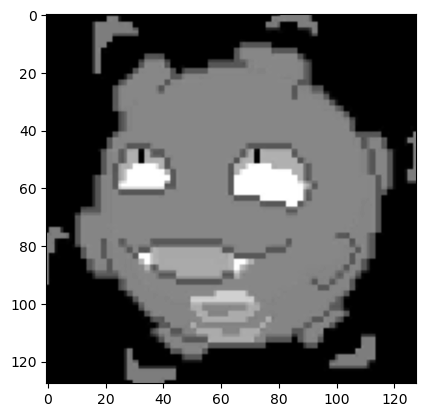

In [39]:
img, y = train_data.__getitem__(0)
print(y, labels_map[y])
print(img.shape)
print(np.unique(img))
plt.imshow(img[0,:,:], cmap='gray')

In [13]:
train_dataloader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=False)

In [14]:
# for batch, (x, y) in enumerate(train_dataloader):
#     if x.shape != (1, 3, 128, 128):
#         print('aaa')

## Model

In [15]:
nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)(img).shape

torch.Size([16, 128, 128])

In [16]:
nn.MaxPool2d(kernel_size=(2, 2))(img).shape

torch.Size([3, 64, 64])

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # 16 x 128 x 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 16 x 64 x 64
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # 32 x 64 x 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 32 x 32 x 32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 64 x 64 x 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 64 x 16 x 16
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(64*16*16, 256), 
            nn.ReLU(),
            nn.Linear(256, 151),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.flatten(out)
        out = self.fc(out)
        
        return out

In [18]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=151, bias=True)
  )
)


In [19]:
def calculate_acc(y_pred, y):
    preds = F.softmax(y_pred, dim=1)
    preds = torch.argmax(preds, dim=1)
    num_correct = (preds == y).sum().item()
    
    # print(preds, y)
    # print((preds == y).sum())

    return num_correct / len(y)

In [20]:
def train(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    avg_loss, avg_acc = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        # Get prediction and compute loss
        y_pred = model(x)

        # print(y_pred.shape, torch.argmax(y_pred[0]), y_pred[0][torch.argmax(y_pred[0])])
        loss = loss_fn(y_pred, y)
        avg_loss += loss.item()

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_acc += calculate_acc(y_pred, y)

        # print(avg_acc)
    
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)
        
    return (avg_loss, avg_acc)

In [21]:
def val(dataloader, model, loss_fn, epoch):    
    model.eval()
    avg_loss, avg_acc = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            avg_loss += loss_fn(y_pred, y).item()
            avg_acc += calculate_acc(y_pred, y)
    
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)
    
    return (avg_loss, avg_acc)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
loss_fn = nn.CrossEntropyLoss()

In [ ]:
epochs = config['epochs']
train_history = {'loss': [], 'acc': []}
val_history = {'loss': [], 'acc': []}
best_epoch = {}
    
for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer, epoch)
    val_loss, val_acc = val(val_dataloader, model, loss_fn, epoch)

    train_history['loss'].append(train_loss)
    train_history['acc'].append(train_acc)

    val_history['loss'].append(val_loss)
    val_history['acc'].append(val_acc)
    
    # if (epoch % 10 == 0):
    print(f'Epoch {epoch}')
    print(f'loss: {train_loss:>5f} acc: {train_acc:>5f}')
    print(f'val loss: {val_loss:>5f} val acc: {val_acc:>5f}')
    # print(f'lr: {optimizer.param_groups[0]["lr"]:>5f}')
    print('-------------------------------')

    if use_wandb:
        wandb.log({'epoch': epoch, 'loss': train_loss, 'accuracy': train_acc, 'val_loss':val_loss, 'val_accuracy': val_acc, 'lr': optimizer.param_groups[0]["lr"]})

In [78]:
# torch.save(model.state_dict(), 'models/overfitted.pt')
# model = torch.load('models/overfitted.pt')

In [43]:
if use_wandb:
    wandb.finish()

In [44]:
fig = px.line({'loss': train_history['loss'], 'val_loss': val_history['loss']})
fig.show()

In [45]:
fig = px.line({'acc': train_history['acc'], 'val_acc': val_history['acc']})
fig.show()

In [145]:
def plot_img(img, label):
    print(f'Original image: {label.item()} {labels_map[label.item()]}')
    plt.imshow(img[0,:,:], cmap='gray')

Original image: 105 Poliwag
Predicted: 105 Poliwag


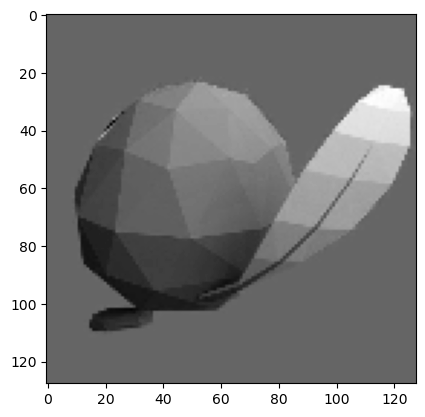

In [148]:
model.eval()
index = 127
with torch.no_grad():
    x, y = next(iter(train_dataloader))
    plot_img(x[index], y[index])
    
    x = x.to(device)
    y_pred = model(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred_labels = torch.argmax(y_pred, dim=1)
    
    print('Predicted:', y_pred_labels[index].item(), labels_map[y_pred_labels[index].item()])
    # print(y_pred_labels)

# Playground

In [46]:
for img in data:
    img_path = os.path.join(data_dir, img)
    image = read_image(img_path)
    # if image.shape[1] > 2000:
    print(img_path)
    break

data/PokemonData/Zapdos/Zapdos60.jpg


torch.Size([3, 592, 592])


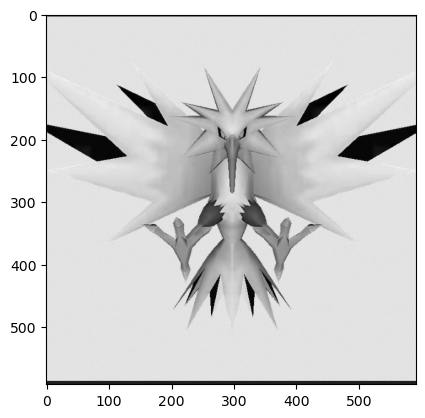

In [47]:
image = read_image('data/PokemonData/Zapdos/Zapdos1.jpg')
print(image.shape)
plt.imshow(image[0, :, :], cmap='gray')

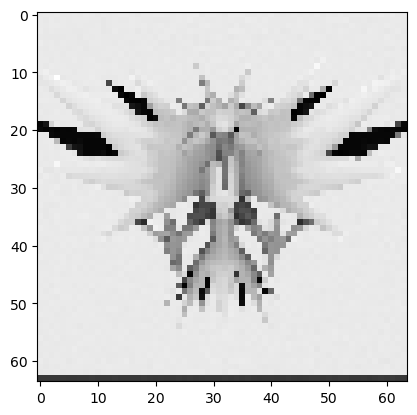

In [48]:
transform = transforms.Resize((64, 64))
plt.imshow(transform(image)[0, :, :], cmap='gray')

In [49]:
print(y, labels_map[y])
plt.imshow(img[0, :, :], cmap='gray')
plt.axis(False)

66 Koffing


TypeError: string indices must be integers